In [1]:
# install rdkit  
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit python=3.7
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import pprint     
pprint.pprint(sys.path)
!python -c "import site; print (site.getsitepackages())"

--2022-08-23 07:07:28--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-08-23 07:07:28--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ failed with initial frozen solve. Re

In [2]:
from rdkit import Chem
from rdkit.Chem import rdchem
import re
Chiral = {"CHI_UNSPECIFIED":0,  "CHI_TETRAHEDRAL_CW":1, "CHI_TETRAHEDRAL_CCW":2, "CHI_OTHER":3}

Hybridization = {"UNSPECIFIED":0, "S":1, "SP":2, "SP2":3, "SP3":4, "SP3D":5, "SP3D2":6, "OTHER":7}

atomInfo = 21
structInfo = 21
lensize= atomInfo + structInfo

H_Vector = [0]*atomInfo
H_Vector[0]= 1

lowerReg = re.compile(r'^[a-z]+$')
def islower(s):
    return lowerReg.match(s) is not None

upperReg = re.compile(r'^[A-Z]+$')
def isupper(s):
    return upperReg.match(s) is not None

def calc_atom_feature(atom):
    
    if atom.GetSymbol() == 'H':   feature = [1,0,0,0,0]
    elif atom.GetSymbol() == 'C': feature = [0,1,0,0,0]
    elif atom.GetSymbol() == 'O': feature = [0,0,1,0,0]
    elif atom.GetSymbol() == 'N': feature = [0,0,0,1,0]
    else: feature = [0,0,0,0,1]
        
    feature.append(atom.GetTotalNumHs()/8)
    feature.append(atom.GetTotalDegree()/4)
    feature.append(atom.GetFormalCharge()/8)
    feature.append(atom.GetTotalValence()/8)
    feature.append(atom.IsInRing()*1)
    feature.append(atom.GetIsAromatic()*1)

    f =  [0]*(len(Chiral)-1)
    if Chiral.get(str(atom.GetChiralTag()), 0) != 0:
        f[Chiral.get(str(atom.GetChiralTag()), 0)] = 1
    feature.extend(f)

    f =  [0]*(len(Hybridization)-1)
    if Hybridization.get(str(atom.GetHybridization()), 0) != 0:
        f[Hybridization.get(str(atom.GetHybridization()), 0)] = 1
    feature.extend(f)
    
    return(feature)


def calc_structure_feature(c,flag,label):
    feature = [0]*structInfo

    if c== '(' :
        feature[0] = 1
        flag = 0
    elif c== ')' :
        feature[1] = 1
        flag = 0
    elif c== '[' :
        feature[2] = 1
        flag = 0
    elif c== ']' :
        feature[3] = 1
        flag = 0
    elif c== '.' :
        feature[4] = 1
        flag = 0
    elif c== ':' :
        feature[5] = 1
        flag = 0
    elif c== '=' :
        feature[6] = 1
        flag = 0
    elif c== '#' :
        feature[7] = 1
        flag = 0
    elif c== '\\':
        feature[8] = 1
        flag = 0
    elif c== '/' :
        feature[9] = 1
        flag = 0  
    elif c== '@' :
        feature[10] = 1
        flag = 0
    elif c== '+' :
        feature[11] = 1
        flag = 1
    elif c== '-' :
        feature[12] = 1
        flag = 1
    elif c.isdigit() == True:
        if flag == 0:
            if c in label:
                feature[20] = 1
            else:
                label.append(c)
                feature[19] = 1
        else:
            feature[int(c)-1+12] = 1
            flag = 0
    return(feature,flag,label)


def calc_featurevector(mol, smiles,atomsize):
    flag = 0
    label = []
    molfeature=[]
    idx = 0
    j = 0
            
    for c in smiles:
        if islower(c) == True: continue
        elif isupper(c) == True:
            if c == 'H':
                molfeature.extend(H_Vector)
            else:
                molfeature.extend(calc_atom_feature(rdchem.Mol.GetAtomWithIdx(mol, idx)))
                idx = idx + 1
            molfeature.extend([0]*structInfo)
            j = j +1
            
        else:   
            molfeature.extend([0]*atomInfo)
            f,flag,label = calc_structure_feature(c,flag,label)
            molfeature.extend(f)
            j = j +1

    #0-Padding
    molfeature.extend([0]*(atomsize-j)*lensize)        
    return(molfeature)


def mol_to_feature(mol,n,atomsize):
    try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(n))
    except: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True)
    try: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(n))
    except: isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True)
    return calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize)

def mol_to_allSMILESfeature(mol, atomsize):
    idx, features =0,  []
    while idx < mol.GetNumAtoms():
        try: defaultSMILES = Chem.MolToSmiles(mol, kekuleSmiles=False, isomericSmiles=True, rootedAtAtom=int(idx))
        except: break
        isomerSMILES = Chem.MolToSmiles(mol, kekuleSmiles=True, isomericSmiles=True, rootedAtAtom=int(idx))
        features.append(calc_featurevector(Chem.MolFromSmiles(defaultSMILES), isomerSMILES,atomsize))
        idx = idx + 1
    return(features)



In [3]:
import pandas as pd
df = pd.read_csv('top_20_MOAs.txt', sep = '\t')
df

,SMILES,MOA
0,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O,adrenergic receptor antagonist
1,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1,adrenergic receptor antagonist
2,CC(C)NCC(O)COc1ccccc1CC=C,adrenergic receptor antagonist
3,COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1,adrenergic receptor antagonist
4,CC(C)(C)NCC(O)CSc1nc(cs1)-c1ccc(s1)C(N)=O,adrenergic receptor antagonist
...,...,...
1216,OCCCC(O)=O,benzodiazepine receptor agonist
1217,CN1c2ccc(Cl)cc2C(=NC(O)C1=O)c1ccccc1,benzodiazepine receptor agonist
1218,CCN(C(C)=O)c1cccc(c1)-c1ccnc2c(cnn12)C#N,benzodiazepine receptor agonist
1219,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,benzodiazepine receptor agonist


In [4]:
# check the duplicates 
for i in df.SMILES.tolist():
  if df.SMILES.tolist().count(i) != 1:
    print(i)

In [5]:
MOA_class_dictionary = {'EGFR inhibitor': 8,
 'HDAC inhibitor': 16,
 'PI3K inhibitor': 13,
 'acetylcholine receptor agonist': 1,
 'acetylcholine receptor antagonist': 4,
 'adrenergic receptor agonist': 18,
 'adrenergic receptor antagonist': 15,
 'bacterial cell wall synthesis inhibitor': 14,
 'benzodiazepine receptor agonist': 10,
 'calcium channel blocker': 5,
 'cyclooxygenase inhibitor': 6,
 'dopamine receptor antagonist': 12,
 'glucocorticoid receptor agonist': 9,
 'glutamate receptor antagonist': 19,
 'histamine receptor antagonist': 17,
 'phosphodiesterase inhibitor': 3,
 'serotonin receptor agonist': 7,
 'serotonin receptor antagonist': 2,
 'sodium channel blocker': 11,
 'topoisomerase inhibitor': 0}

In [6]:
sorted_classes = list(MOA_class_dictionary.values())
sorted_classes.sort() 
assert sorted_classes == [i for i in range(20)]

In [7]:
# add classes column 
df['classes'] = None
for i in range(df.shape[0]):
  df.iloc[i,2] = MOA_class_dictionary[df.iloc[i,1]]
df

,SMILES,MOA,classes
0,CCCC(=O)Nc1ccc(OCC(O)CNC(C)C)c(c1)C(C)=O,adrenergic receptor antagonist,15
1,COc1cc2nc(nc(N)c2cc1OC)N(C)CCCNC(=O)C1CCCO1,adrenergic receptor antagonist,15
2,CC(C)NCC(O)COc1ccccc1CC=C,adrenergic receptor antagonist,15
3,COc1ccccc1N1CCN(CCN2C(=O)c3ccccc3C(C)(C)C2=O)CC1,adrenergic receptor antagonist,15
4,CC(C)(C)NCC(O)CSc1nc(cs1)-c1ccc(s1)C(N)=O,adrenergic receptor antagonist,15
...,...,...,...
1216,OCCCC(O)=O,benzodiazepine receptor agonist,10
1217,CN1c2ccc(Cl)cc2C(=NC(O)C1=O)c1ccccc1,benzodiazepine receptor agonist,10
1218,CCN(C(C)=O)c1cccc(c1)-c1ccnc2c(cnn12)C#N,benzodiazepine receptor agonist,10
1219,CCOC(=O)c1ncc2[nH]c3ccc(OCc4ccccc4)cc3c2c1COC,benzodiazepine receptor agonist,10


In [8]:
# A function that changes smiles string to fingerprints 
import rdkit
import numpy as np
from rdkit import *
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
def smiles_to_array_to_string(smiles):
  molecules = Chem.MolFromSmiles(smiles) 
  fingerprints = AllChem.GetMorganFingerprintAsBitVect(molecules, 2)
  x_array = []
  arrays  = np.zeros(0,)
  DataStructs.ConvertToNumpyArray(fingerprints, arrays)
  x_array.append(arrays)
  x_array = np.asarray(x_array)
  x_array = list((np.squeeze(x_array)).astype(int))
  string = ''
  for i in x_array:
    string += str(i) 
  return string

In [9]:
# Check the existence of Isomers
assert len(set([smiles_to_array_to_string(i) for i in df.SMILES.tolist()])) == df.shape[0]

In [10]:
# Split out the test set  
from sklearn.model_selection import train_test_split
x_train_valid, x_test, y_train_valid, y_test = train_test_split(df.SMILES, df.classes, test_size =10/100,
 stratify = df.classes, shuffle = True, random_state = 1000)

In [11]:
# kfold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 9)
skf.get_n_splits(np.array(list(x_train_valid)), np.array(list(y_train_valid)))
train_index_list = []
valid_index_list = []
for train_index, valid_index in skf.split(np.array(list(x_train_valid)), np.array(list(y_train_valid))):
  train_index_list.append(train_index)
  valid_index_list.append(valid_index)


In [12]:
number_of_kfold = 0 # change the number from 0-8 to get 9 shuffles

In [13]:
  x_train = list(np.array(list(x_train_valid))[train_index_list[ number_of_kfold ]])
  x_valid = list(np.array(list(x_train_valid))[valid_index_list[ number_of_kfold ]])
  y_train = list(np.array(list(y_train_valid))[train_index_list[ number_of_kfold ]])
  y_valid = list(np.array(list(y_train_valid))[valid_index_list[ number_of_kfold ]])
  x_test = list(x_test)
  y_test = list(y_test)

In [14]:
# Check if there are overlaps
overlap = []
for i in x_valid:
  if i in x_train:
    overlap.append(i)
    print(i)

In [15]:
for i in x_test:
  if i in x_train:
    overlap.append(i)
    print(i)

In [16]:
for i in x_test:
  if i in x_valid:
    overlap.append(i)
    print(i)

In [17]:
assert len(overlap) == 0

In [18]:
import gc               
gc.collect()

0

In [19]:
x_all = list(x_train) + list(x_valid) + list(x_test)
y_all = list(y_train) + list(y_valid) + list(y_test)

In [20]:
import pandas as pd
pd_x_all = pd.DataFrame(x_all)
pd_x_all['labels'] = y_all
pd_x_all

,0,labels
0,COc1cc(N(C)CCN(C)C)c(NC(=O)C=C)cc1Nc1nccc(n1)-...,8
1,CC[C@@]12CCCN3CCc4c([C@H]13)n(c1ccccc41)[C@@](...,15
2,C[C@H]1CC2C3CCC(C(C)=O)C3(C)CC(O)C2C2(C)CCC(=O...,9
3,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc12,8
4,CC1(CN)Cc2ccccc2C1,15
...,...,...
1216,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)\C=C\C...,8
1217,CC(C(=O)Nc1cc(C)ccn1)c1cccc(c1)C(=O)c1ccccc1,6
1218,CN1CCc2cc(Br)c(O)cc2C(C1)c1ccccc1,12
1219,NCC(CC(O)=O)c1ccccc1,10


In [21]:
pd_x_all.to_csv('6663.txt', sep = ' ', index = False, header = False,)

In [22]:
pip install chainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import SCFPfunctions as Mf
xp = np 
file = '6663.txt'
smi = Chem.SmilesMolSupplier(file, delimiter=' ', titleLine = False)
mols = [mol for mol in smi if mol is not None]

/usr/local/lib/python3.7/site-packages/chainer/_environment_check.py:75: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy-cuda111) version 9.4.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy-cuda111>=7.7.0,<8.0.0'

See the following page for more details:
  https://docs.cupy.dev/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [24]:
F_list, T_list = [], []
for mol in mols:
  F_list.append(mol_to_feature(mol,-1,500))
  T_list.append(mol.GetProp('_Name'))
 
data_f = xp.asarray(F_list, dtype = xp.float32).reshape(-1, 1, 500, lensize)
data_t = xp.asarray(T_list, dtype = xp.int32).reshape(-1, 1)

dataset = (data_f, data_t)
print(data_t.shape, data_f.shape)

(1221, 1) (1221, 1, 500, 42)


In [25]:
x, y = dataset[0].T, dataset[1]
x = np.moveaxis(x, -1, 0)
x.shape

(1221, 42, 500, 1)

In [26]:
import tensorflow as tf
from os import path, getcwd, chdir

In [27]:
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config = config)

In [28]:
x_train = x[0:len(x_train)] 
x_valid = x[len(x_train):len(x_train) + len(x_valid)]  
x_test = x[len(x_train) + len(x_valid):len(x_train) + len(x_valid) + len(x_test)] 

In [29]:
y_list = [int(i) for i in y]
Y_train = y_list[0:len(x_train)] 
Y_valid = y_list[len(x_train):len(x_train) + len(x_valid)]  
Y_test = y_list[len(x_train) + len(x_valid):len(x_train) + len(x_valid) + len(x_test)] 

In [30]:
assert np.array_equal(np.array(y_train), np.array(Y_train)) == True
assert np.array_equal(np.array(y_valid), np.array(Y_valid)) == True 
assert np.array_equal(np.array(y_test), np.array(Y_test)) == True 

In [31]:
train_Y = y_train
y_unique = np.unique(np.array(train_Y))
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = y_unique,
                       y = np.array(train_Y)) 
class_weights_dict45 = dict(enumerate(class_weights))
class_weights_dict45

{0: 1.6266666666666667,
 1: 1.4352941176470588,
 2: 0.8872727272727273,
 3: 0.976,
 4: 0.7283582089552239,
 5: 1.3555555555555556,
 6: 0.6177215189873417,
 7: 0.9959183673469387,
 8: 1.525,
 9: 1.318918918918919,
 10: 1.7428571428571429,
 11: 1.5741935483870968,
 12: 0.976,
 13: 1.4352941176470588,
 14: 0.6506666666666666,
 15: 0.6506666666666666,
 16: 1.5741935483870968,
 17: 0.8714285714285714,
 18: 0.7283582089552239,
 19: 0.8133333333333334}

In [32]:
drop = 0.8  
model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(8,(3,3),activation='relu',input_shape=(42, 500, 1)),
            tf.keras.layers.MaxPool2D((3,3)),
            tf.keras.layers.Dropout(drop),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(drop),
            tf.keras.layers.Dense(units = len(set(y_list)), activation='softmax')])

In [33]:
from keras.callbacks import ModelCheckpoint
filepath_cnn = '/content/'+'CNN_20_MOA_weights.hdf5'
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='val_accuracy', verbose=0, save_best_only=True,
              mode='max')

In [34]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),  
       loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
       metrics = ['accuracy']) 

In [35]:
from tensorflow.keras.callbacks import EarlyStopping  
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 0, mode = 'min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
           factor = 0.89, patience = 7, verbose = 1, min_delta = 1e-119, mode = 'min')
history = model.fit(x_train, np.array(y_train), validation_data=(x_valid, np.array(y_valid)),
           class_weight = class_weights_dict45, shuffle = True, verbose = 2, epochs = 1800,
           batch_size = 64, callbacks=[earlyStopping, checkpoint_cnn, reduce_lr_loss])

Epoch 1/1800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 - 3s - loss: 3.0406 - accuracy: 0.0615 - val_loss: 2.9053 - val_accuracy: 0.1148 - lr: 0.0010 - 3s/epoch - 170ms/step
Epoch 2/1800
16/16 - 0s - loss: 2.9652 - accuracy: 0.1045 - val_loss: 2.8444 - val_accuracy: 0.1639 - lr: 0.0010 - 147ms/epoch - 9ms/step
Epoch 3/1800
16/16 - 0s - loss: 2.9338 - accuracy: 0.1168 - val_loss: 2.8163 - val_accuracy: 0.1721 - lr: 0.0010 - 138ms/epoch - 9ms/step
Epoch 4/1800
16/16 - 0s - loss: 2.8568 - accuracy: 0.1168 - val_loss: 2.7916 - val_accuracy: 0.1803 - lr: 0.0010 - 146ms/epoch - 9ms/step
Epoch 5/1800
16/16 - 0s - loss: 2.8157 - accuracy: 0.1342 - val_loss: 2.7654 - val_accuracy: 0.1967 - lr: 0.0010 - 166ms/epoch - 10ms/step
Epoch 6/1800
16/16 - 0s - loss: 2.7976 - accuracy: 0.1516 - val_loss: 2.7375 - val_accuracy: 0.2377 - lr: 0.0010 - 130ms/epoch - 8ms/step
Epoch 7/1800
16/16 - 0s - loss: 2.7874 - accuracy: 0.1588 - val_loss: 2.7139 - val_accuracy: 0.2131 - lr: 0.0010 - 102ms/epoch - 6ms/step
Epoch 8/1800
16/16 - 0s - loss: 2.7083 - accura

In [36]:
from keras.models import load_model
best_model = load_model(filepath_cnn)

In [37]:
# Evaluate the model 
from sklearn.metrics import classification_report
assert list(y_test)[0:5] == [14, 12, 6, 13, 14]
print(classification_report(y_valid, np.array(best_model.predict(x_valid).argmax(-1)),))
print(classification_report(y_test, np.array(best_model.predict(x_test).argmax(-1)),))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.23      0.60      0.33         5
           2       0.18      0.29      0.22         7
           3       0.50      0.33      0.40         6
           4       0.20      0.12      0.15         8
           5       0.00      0.00      0.00         5
           6       0.36      0.40      0.38        10
           7       0.09      0.17      0.12         6
           8       0.75      0.75      0.75         4
           9       0.67      1.00      0.80         4
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         4
          12       0.20      0.14      0.17         7
          13       0.38      0.75      0.50         4
          14       0.78      0.70      0.74        10
          15       0.40      0.20      0.27        10
          16       0.33      0.25      0.29         4
          17       0.25    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


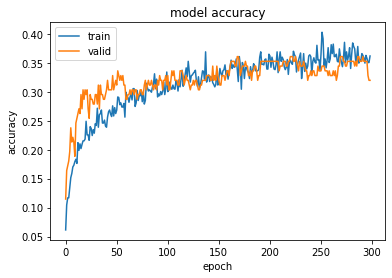

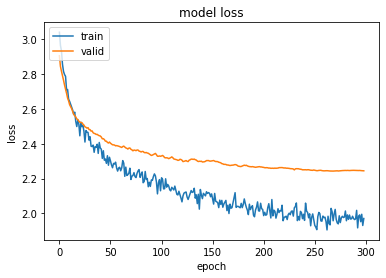

In [38]:
# Training curves
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc = 'upper left')
plt.show()

In [39]:
# References 
# http://www.dna.bio.keio.ac.jp/smiles/
# https://github.com/pharmbio/dl_quantmap/tree/master/cross_validation/CNN